# Multi-layer FNN on MNIST

This is MLP (784-X^W-10) on MNIST. SGD algorithm (lr=0.1) with 100 epoches.

 

In [ ]:
import os, sys
import numpy as np
from matplotlib.pyplot import *
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import itertools


%matplotlib inline

In [88]:
""" Extract final stats from resman's diary file"""
def extract_num(lines0):

    valid_loss_str     = lines0[-5]
    valid_accuracy_str = lines0[-6]
    train_loss_str     = lines0[-8]
    train_accuracy_str = lines0[-9]
    run_time_str       = lines0[-10]

    valid_loss     = float(valid_loss_str.split( )[-1])
    valid_accuracy = float(valid_accuracy_str.split( )[-1])
    train_loss     = float(train_loss_str.split( )[-1])
    train_accuracy = float(train_accuracy_str.split( )[-1])
    run_time       = float(run_time_str.split( )[-1])
    
    return valid_loss, valid_accuracy, train_loss, train_accuracy, run_time

""" Extract number of total parameters for each net config from resman's diary file"""
def parse_num_params(lines0):
    line_str = ''.join(lines0)
    idx = line_str.find("Total params")
    param_str = line_str[idx+14:idx+14+20] # 14 is the length of string "Total params: "
    param_num = param_str.split("\n")[0]
    return int(locale.atof(param_num))

In [89]:
""" Extract total params for each net config from resman's diary file"""
def parse_acc(lines0):
    line_str = ''.join(lines0)
    # print lines0

    idx = line_str.find("Total params")
    # print idx
    val_acc_str = line_str[idx+14:idx+14+30] # 14 is the length of string "Total params: "
    param_num = val_acc_str.split("\n")[0].replace(",", "")
    return int(param_num)

#### Extract results from diary file

    1. Number of params
    2. Loss/Accuarcy for training/testing
    3. Runing time

In [98]:
def contruct_results_tensors(results_dir):
    depth = [1,2,3,4,5]
    width = [50,100,200]
    dim   = [0,10,50,100,200,300,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,850,900,1000,1250,1500]


    ########## 1. filename list of diary ########################
    diary_names = []
    for subdir, dirs, files in os.walk(results_dir):
        for file in files:
            if file == 'diary':
                fname = os.path.join(subdir, file)
                diary_names.append(fname)


    ########## 2. Construct stats (width, depth, dim) ##########
    # acc_test_all : Tensor (width, depth, dim)
    # num_param_all: Tensor (width, depth)
    # acc_solved_all:  Tensor (width, depth)
    # dim_solved_all:  Tensor (width, depth)
    ############################################################
    nw, nd, nn= len(width), len(depth), len(dim)

    acc_test_all  = np.zeros((len(width), len(depth), len(dim)))
    nll_test_all  = np.zeros((len(width), len(depth), len(dim)))
    num_param_all = np.zeros((len(width), len(depth)))
    run_time_all  = np.zeros((len(width), len(depth), len(dim)))


    mode = 1         # {0: test loss, 1: test acc}
    error_files = [] #  record the error file

    # 2.1 construct acc_test_all and num_param_all
    for id_w in range(len(width)):
        w = width[id_w]
        for id_ll in range(len(depth)):
            ll = depth[id_ll]
            for id_d in range(len(dim)):
                d = dim[id_d]


                # 2.1.1 Read the results, 
                for f in diary_names:
                    if '_'+str(d)+'_'+str(ll)+'_'+str(w)+'/' in f:
                        # print "%d is in" % d + f

                        with open(f,'r') as ff:
                            lines0 = ff.readlines()

                            try:
                                R = extract_num(lines0)
                                R = np.array(R)
                                params = parse_acc(lines0)

                            except ValueError:
                                error_files.append((w,ll,d))
                                R = np.zeros(len(R))
                                print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
                                # break


                # 2.1.2 Assign the results
                nll = R[0]
                r = R[1]
                t = R[4]
                acc_test_all[id_w,id_ll,id_d]=r
                nll_test_all[id_w,id_ll,id_d]=nll
                run_time_all[id_w,id_ll,id_d]=t
                if d==0:
                    num_param_all[id_w,id_ll]=parse_num_params(lines0) 

    return nll_test_all, acc_test_all, run_time_all, num_param_all

In [104]:
depth = [1,2,3,4,5]
width = [50,100,200]
dim   = [0,10,50,100,200,300,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,850,900,1000,1250,1500]

results_dir = '../results/fnn_mnist_l2_sparse'
nll_test_sparse, acc_test_sparse, run_time_sparse, num_param_sparse = contruct_results_tensors(results_dir)

results_dir = '../results/fnn_mnist_l2_dense'
nll_test_dense, acc_test_dense, run_time_dense, num_param_dense = contruct_results_tensors(results_dir)


In [25]:
# 2.2 construct acc_solved_all and dim_solved_all           

acc_solved_all = np.zeros((len(width), len(depth)))
dim_solved_all = np.zeros((len(width), len(depth)))
    
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]

            r = acc_test_all[id_w,id_ll,id_d]
            if d==0:
                test_acc_bl = 1.0 # r        
                # print "Acc goal is: " + str(test_acc_sl) + " for network with depth " + str(ll) + " width "+ str(w)
            else:
                test_acc = r
                if test_acc>test_acc_bl*0.9:
                    acc_solved_all[id_w,id_ll]=test_acc
                    dim_solved_all[id_w,id_ll]=d
                    # print "Intrinsic dim is: " + str(d) + " for network with depth " + str(ll) + " width "+ str(w)
                    # print "\n"
                    break

########## 3. Construct Tensors for Analysis (width, depth, dim) ##########                    
acc_base  = acc_test_all[:,:,0]
acc_solve = acc_base*0.9

In [26]:
print "Baseline results"
print acc_test_all[:,:,0]

print "# Parmas"
print num_param_all

print "Cross-line results"
print acc_solved_all

print "Cross-line Dim"
print dim_solved_all

print "Dim %d results" % dim[-2]
print acc_test_all[:,:,-2]  
print run_time_all[:,:,-2]  


Baseline results
[[ 0.9758  0.969   0.9646  0.9692  0.1135]
 [ 0.9799  0.9831  0.9823  0.9811  0.9784]
 [ 0.9823  0.9829  0.9843  0.9831  0.9831]
 [ 0.983   0.9852  0.9843  0.9856  0.983 ]]
# Parmas
<function parse_num_params at 0x7f532db8a2a8>
Cross-line results
[[ 0.9001  0.901   0.9004  0.9072  0.9119]
 [ 0.9038  0.9045  0.901   0.903   0.9013]
 [ 0.9004  0.9003  0.9012  0.9083  0.9032]
 [ 0.9021  0.9007  0.9005  0.904   0.9001]]
Cross-line Dim
[[ 650.  575.  650.  675.  675.]
 [ 675.  625.  625.  625.  625.]
 [ 650.  625.  650.  650.  625.]
 [ 775.  650.  650.  725.  675.]]
Dim 1250 results
[[ 0.9324  0.9329  0.935   0.9292  0.923 ]
 [ 0.9308  0.9338  0.9309  0.9345  0.9285]
 [ 0.9243  0.9316  0.9298  0.9311  0.9261]
 [ 0.928   0.9278  0.9291  0.9261  0.9256]]
[[ 114.078  284.308  141.664  156.886  166.606]
 [ 128.59   134.432  138.162  153.425  167.141]
 [ 120.698  125.524  147.943  186.251  176.528]
 [ 120.02   131.825  162.468  229.579  196.215]]


#### List the config of depth and width, which yields errors in training

In [ ]:
E_width, E_depth, E_dim = [],[],[]
for item in error_files:
    E_width.append(item[0]) 
    E_depth.append(item[1])
    E_dim.append(item[2])

str_E_width = "".join(str(E_width)).replace(',', '')
str_E_depth = "".join(str(E_depth)).replace(',', '')
str_E_dim   = "".join(str(E_dim)).replace(',', '')

print "Error in the following configs: width, depth and dim"
print str_E_width
print str_E_depth
print str_E_dim

print "Shape of accuracy tensor: " + str(acc_test_all.shape)

-------------------------

#### Check the accuracy of specific depth and width, along different dim

In [ ]:
def check_cfg_results(depth, width, lines0): 
    for d in dim:
        # 1. read the results
        for f in diary_names:
            if '_'+str(d)+'_'+str(depth)+'_'+str(width)+'/' in f:
                # print "%d is in" % d + f
                diary_names_ordered.append(f)
                with open(f,'r') as ff:
                    lines0 = ff.readlines()
                    try:
                        # print lines0
                        param_num = parse_num_params(lines0)
                        R = extract_num(lines0)
                        print R[1]

                    except ValueError:
                        print "Error: Can not read"
                        break

check_cfg_results(2, 200, lines0)                     

Reshape the tensor to 1D for plots

In [ ]:
fig_width = width*len(depth)
fig_depth = list(itertools.chain.from_iterable(itertools.repeat(x, len(width)) for x in depth))

print fig_width
print fig_depth
print num_param_all
print dim_solved_all
fig_params_1d = num_param_all.reshape(len(depth)*len(width),order='F')
dim_solved_all_1d = dim_solved_all.reshape(len(depth)*len(width),order='F')
acc_solved_all_1d = acc_solved_all.reshape(len(depth)*len(width),order='F')
print fig_params_1d
print dim_solved_all_1d

### Testing Accuracy wrt. Width, Depth and Dim

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

plt.figure(figsize=(20,5.0))

for i in range(acc_test_all.shape[2]):
    acc = acc_test_all[:,:,i].reshape(len(depth)*len(width),order='F')
    if i==0:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, edgecolors='k') 
        plt.scatter(fig_params_1d, 0.9*acc, marker="_", s=300, c='k', edgecolors='r') 
    else:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, facecolors='None', linewidth=np.array(dim[i])/300.0) 

        
ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.8, 1.0)
ax.set_xlim(0.3E4, 1.5E6)

plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/1000, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, loc='best', bbox_to_anchor=(1.25, 1),
             frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

 
    

#### Testing Accuracy of Intrinsic dim for #parameters

In [ ]:
fig = plt.figure(figsize=(16,5))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.scatter(fig_params_1d, acc_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(0.3E5, 1.5E6)


plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

#### Intrinsic dim for #parameters

In [ ]:
fig = plt.figure(figsize=(16,5))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.scatter(fig_params_1d, dim_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')

ax.grid(True)
ax.set_ylim(0, 900)

plt.xlabel('# parameters')
plt.ylabel('# dimension')
ax.set_xlim(0.3E5, 1.5E6)

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w",loc='best')

fig.savefig("fnn_dim_global_sparseM.pdf", bbox_inches='tight')

## Performance comparison with Baseline

In [ ]:
fig = plt.figure(figsize=(35,25))
fig.subplots_adjust(hspace=0.3)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

for i in range(nw):
    for j in range(nd):
        if j>0:
            id = i*nd+j+1
            ax = plt.subplot(nw, nd, id)

            plt.scatter(dim, acc_test_all[i,j,:], edgecolor="k", facecolor="w", s=60 )
            ax.plot(dim, acc_test_all[i,j,0]*np.ones(nn)*0.9,'r-.', label="Testing: baseline")
            ax.set_xlabel('Intrinsic Dim')
            ax.set_ylabel('Accuracy')
            ax.set_title('width %d, depth %d' %(width[i], depth[j]))
            plt.grid()
            ax.set_ylim([-0.1,1.1])

fig.savefig("fnn_all_configs_sparseM.pdf", bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(35,18))
# fig, ax = subplots(figsize=(5,4))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

nn = len(dim)

sr = acc_test_all[2,2,0]*0.9

ax = plt.subplot(nw, nd, id)

plt.scatter(dim[1:], acc_test_all[2,2,1:], edgecolor="k", facecolor="w" )
ax.plot(dim, acc_test_all[i,j,0]*np.ones(nn)*sr,'r-.', label="Testing: baseline")
ax.set_xlabel('Intrinsic Dim')
ax.set_ylabel('Accuracy')
# ax.set_title('width %d, depth %d' %(width[i], depth[j]))
plt.grid()
ax.set_ylim([-0.1,1.1])
# fig.set_size_inches(5, 4)
        
fig.savefig("fnn_mnist_sparseM.pdf", bbox_inches='tight')        


In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

plt.figure(figsize=(20,5.0))

for i in range(run_time_all.shape[2]):
    acc = run_time_all[:,:,i].reshape(len(depth)*len(width),order='F')
    if i==0:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, edgecolors='k') 
        # plt.scatter(fig_params_1d, 0.9*acc, marker="_", s=300, c='k', edgecolors='r') 
    else:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, facecolors='None', linewidth=np.array(dim[i])/300.0) 

        
ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

# ax.set_ylim(0.8, 1.0)
ax.set_xlim(0.3E4, 1.5E6)

plt.xlabel('#Parameters')
plt.ylabel('Run time (second)')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/1000, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, loc='best', bbox_to_anchor=(1.25, 1),
             frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")


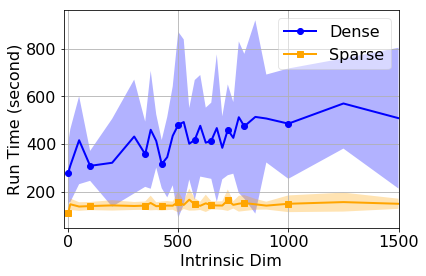

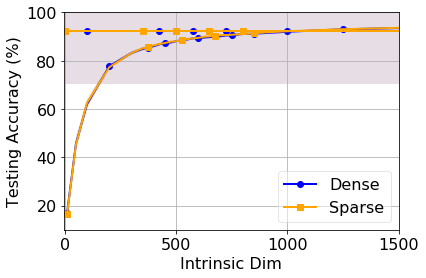

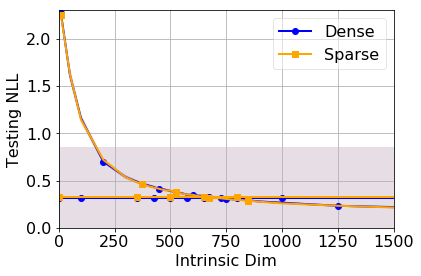

In [105]:
mean_nll_s = nll_test_sparse.mean((0,1))
std_nll_s  = nll_test_sparse.std((0,1))

mean_time_s = run_time_sparse.mean((0,1))
std_time_s  = run_time_sparse.std((0,1))

mean_acc_s = acc_test_sparse.mean((0,1))*100
std_acc_s  = acc_test_sparse.std((0,1))*100


mean_time_d = run_time_dense.mean((0,1))
std_time_d  = run_time_dense.std((0,1))

mean_acc_d = acc_test_dense.mean((0,1))*100
std_acc_d  = acc_test_dense.std((0,1))*100

mean_nll_d = nll_test_dense.mean((0,1))
std_nll_d  = nll_test_dense.std((0,1))



font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

nn = len(dim)

stride = max( int(nn / 10), 1)
stride2 = max( int(nn / 5), 1)

# 1) Running to finish the experiment
fig = plt.figure(figsize=(6,4))
plot(dim, mean_time_d,  'o-', lw=2, label='Dense', color='blue', markevery=stride)
fill_between(dim, mean_time_d+std_time_d, mean_time_d-std_time_d, facecolor='blue', alpha=0.3)
plot(dim, mean_time_s,  's-', lw=2, label='Sparse', color='orange', markevery=stride)
fill_between(dim, mean_time_s+std_time_s, mean_time_s-std_time_s, facecolor='orange', alpha=0.3)
plt.xlabel('Intrinsic Dim')
plt.ylabel('Run Time (second)')
# ax.set_title('width %d, depth %d' %(width[i], depth[j]))
plt.grid()
legend(loc='best', fancybox=True, framealpha=0.5)
plt.xlim([-20,1500])
# plt.ylim([-0.1,1.1])
fig.savefig("fnn_mnist_time_sparse_dense.pdf", bbox_inches='tight')        
plt.show()



# 2) Testing Accuracy: Acc 
fig = plt.figure(figsize=(6,4))

plot(dim, mean_acc_d[0]*np.ones(nn), 'o-',lw=2, label='Dense', color='blue', markevery=stride)
fill_between(dim, (mean_acc_d[0]+std_acc_d[0])*np.ones(nn), (mean_acc_d[0]-std_acc_d[0])*np.ones(nn), facecolor='blue', alpha=0.1)
plot(dim[1:], mean_acc_d[1:], 'o-', lw=2, color='blue', markevery=stride)
fill_between(dim[1:], mean_acc_d[1:]+std_acc_d[1:], mean_acc_d[1:]-std_acc_d[1:], facecolor='blue', alpha=0.1)

plot(dim, mean_acc_s[0]*np.ones(nn),'s-', lw=2,label='Sparse', color='orange', markevery=stride2)
fill_between(dim, (mean_acc_s[0]+std_acc_s[0])*np.ones(nn), (mean_acc_s[0]-std_acc_s[0])*np.ones(nn), facecolor='orange', alpha=0.1)
plot(dim[1:], mean_acc_s[1:], 's-', lw=2, color='orange', markevery=stride2)
fill_between(dim[1:], mean_acc_s[1:]+std_acc_s[1:], mean_acc_s[1:]-std_acc_s[1:], facecolor='orange', alpha=0.1)

plt.xlabel('Intrinsic Dim')
plt.ylabel('Testing Accuracy (%)')
# ax.set_title('width %d, depth %d' %(width[i], depth[j]))
plt.grid()
legend(loc='best', fancybox=True, framealpha=0.5)
plt.xlim([-5,1500])
plt.ylim([10,100])
fig.savefig("fnn_mnist_acc_sparse_dense.pdf", bbox_inches='tight')        
plt.show()


# 3) Testing Loss: NLL 
fig = plt.figure(figsize=(6,4))
plot(dim, mean_nll_d[0]*np.ones(nn), 'o-',lw=2, label='Dense', color='blue', markevery=stride)
fill_between(dim, (mean_nll_d[0]+std_nll_d[0])*np.ones(nn), (mean_nll_d[0]-std_nll_d[0])*np.ones(nn), facecolor='blue', alpha=0.1)
plot(dim[1:], mean_nll_d[1:], 'o-', lw=2, color='blue', markevery=stride)
fill_between(dim[1:], mean_nll_d[1:]+std_nll_d[1:], mean_nll_d[1:]-std_nll_d[1:], facecolor='blue', alpha=0.1)

plot(dim, mean_nll_s[0]*np.ones(nn),'s-', lw=2,label='Sparse', color='orange', markevery=stride2)
fill_between(dim, (mean_nll_s[0]+std_nll_s[0])*np.ones(nn), (mean_nll_s[0]-std_nll_s[0])*np.ones(nn), facecolor='orange', alpha=0.1)
plot(dim[1:], mean_nll_s[1:], 's-', lw=2, color='orange', markevery=stride2)
fill_between(dim[1:], mean_nll_s[1:]+std_nll_s[1:], mean_nll_s[1:]-std_nll_s[1:], facecolor='orange', alpha=0.1)

plt.xlabel('Intrinsic Dim')
plt.ylabel('Testing NLL')
# ax.set_title('width %d, depth %d' %(width[i], depth[j]))
plt.grid()
legend(loc='best', fancybox=True, framealpha=0.5)
plt.xlim([0,1500])
plt.ylim([0.0,2.3])
fig.savefig("fnn_mnist_nll_sparse_dense.pdf", bbox_inches='tight')        
plt.show()



In [101]:
print run_time_dense[:,:,0]
print run_time_sparse[:,:,0]

[[ 179.564  611.431  205.606  199.965  219.243]
 [ 333.152  206.894  190.112  239.077  203.656]
 [ 238.67   205.017  360.31   521.668  246.512]]
[[ 100.478   108.957   106.248   112.534   113.493 ]
 [  93.8947   96.3711  109.9     113.502   120.818 ]
 [ 101.307   108.224   118.039   118.069   121.025 ]]


In [52]:
print std_acc_s
print std_acc_d

[ 21.58527578   3.20531683   2.49994044   2.45833223   1.10384097
   0.50835421   0.50190127   0.70524196   0.58372596   0.51385947
   0.40416938   0.30025471   0.51759959   0.36329725   0.49204968
   0.47547684   0.44360944   0.36021969   0.33203347   0.44045734
   0.51420964   0.35804407   0.32605657   0.40974247   0.40321706
   0.37767476   0.39395093   0.28205594   0.344186     0.30929741]
[ 21.56515616   2.52041478   2.97534939   1.56217029   0.81700972
   0.79665021   0.64138253   0.41243774   0.41398873   0.44825588
   0.47275364   0.51625403   0.37199761   0.45251593   0.43100915
   0.4416283    0.36108725   0.36272794   0.36700954   0.48034247
   0.51051869   0.40722148   0.38257839   0.29954336   0.3229957
   0.36373617   0.45871511   0.35387003   0.38521798   0.312299  ]
